Pipeline

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import copy

In [2]:
add_spaces=0 #va a contar los guiones que aparecen en el genoma de referencia, al hacer el alineado
temp=0

#Lee el archivo FASTA y manda los nombres y secuencias a un diccionario
with open('varios_recombinantes.fasta') as f:
  sequences = {} #inicializa el diccionario
  name = None
  for line in f:
    line = line.strip()
    if line.startswith('>'):  
      name = line[1:]
      sequences[name] = ''
    else:
      sequences[name] += line
      if temp == 0:
        #Encuentra la cantidad de espacios iniciales "-" para saber cuántas posiciones están alineadas antes de que empiece la secuencia real.
        while line[add_spaces]=='-': add_spaces+=1
        temp = 1

print(add_spaces)

25


In [3]:
#Imprime las secuencias encontradas.
print("Secuencias:")
for name in sequences.values():
  print(name)

Secuencias:
-------------------------AACAAACCAACCAACTTTCGATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTGGCTGTCACTCGGCTGCATGCTTAGTGCACTCACGCAGTATAATTAATAACTAATTACTGTCGTTGACAGGACACGAGTAACTCGTCTATCTTCTGCAGGCTGCTTACGGTTTCGTCCGTTTTGCAGCCGATCATCAGCACATCTAGGTTTTGTCCGGGTGTGACCGAAAGGTAAGATGGAGAGCCTTGTCCCTGGTTTCAACGAGAAAACACACGTCCAACTCAGTTTGCCTGTTTTACAGGTTCGCGACGTGCTCGTACGTGGCTTTGGAGACTCCGTGGAGGAGGTCTTATCAGAGGCACGTCAACATCTTAAAGATGGCACTTGTGGCTTAGTAGAAGTTGAAAAAGGCGTTTTGCCTCAACTTGAACAGCCCTATGTGTTCATCAAACGTTCGGATGCTCGAACTGCACCTCATGGTCATGTTATGGTTGAGCTGGTAGCAGAACTCGAAGGCATTCAGTACGGTCGTAGTGGTGAGACACTTGGTGTCCTTGTCCCTCATGTGGGCGAAATACCAGTGGCTTACCGCAAGGTTCTTCTTCGTAAGAACGGTAATAAAGGAGCTGGTGGCCATAGTTACGGCGCCGATCTAAAGTCATTTGACTTAGGCGACGAGCTTGGCACTGATCCTTATGAAGATTTTCAAGAAAACTGGAACACTAAACATAGCAGTGGTGTTACCCGTGAACTCATGCGTGAGCTTAACGGAGGGGCATACACTCGCTATGTCGATAACAACTTCTGTGGCCCTGATGGCTACCCTCTTGAGTGCATTAAAGACCTTCTAGCACGTGCTGGTAAAGCTTCATGCACTTTGTCCGAACAACTGGACTTTATTGACACTAAGAGGGGTGTATACTGCTGCCGTGAACATGAGCATGAAATTGCTTGGTAC

In [4]:
#Imprime los nombres de las secuencias encontradas.
print("Secuencias:")
i = 0
for name in sequences.keys():
  print(str(i)+' '+name)
  i=i+1
#POR QUÉ NO DETECTA LA OTRA DE BOTSWANA?

Secuencias:
0 hCoV-19/Italy/LAZ-IFO-2310023074/2021|EPI_ISL_18372776|2021-12-09
1 hCoV-19/Bulgaria/s6770/2021|EPI_ISL_18443208|2021-09-01
2 hCoV-19/Italy/LAZ-IFO-2310023065/2021|EPI_ISL_18372767|2021-12-09
3 hCoV-19/France/un-IHUMI-049962/2021|EPI_ISL_18183784|2021-11
4 hCoV-19/France/un-IHUMI-048369/2021|EPI_ISL_18183559|2021-11
5 hCoV-19/India/GA-NCCS-586999988/2021|EPI_ISL_15157245|2021-11-29
6 hCoV-19/India/OR-ILSGS17529/2022|EPI_ISL_14749025|2022-02-02
7 hCoV-19/Mexico/COA-SEARCH-122862/2021|EPI_ISL_13529902|2021-11-14
8 hCoV-19/Mexico/ROO_LANGEBIO_IMSS_4786/2021|EPI_ISL_8910825|2021-12-13
9 hCoV-19/Mexico/MEX-INMEGEN-43-137/2021|EPI_ISL_7852313|2021-12-09
10 hCoV-19/Mexico/CMX-INMEGEN-45-50/2021|EPI_ISL_8186810|2021-12-14
11 hCoV-19/Mexico/CMX-INMEGEN-43-16/2021|EPI_ISL_7852211|2021-12-07
12 hCoV-19/Mexico/NLE_IBT_IMSS_4151/2021|EPI_ISL_6863312|2021-10-31
13 hCoV-19/Mexico/MEX-INMEGEN-38-83/2021|EPI_ISL_6960774|2021-11-22
14 hCoV-19/Mexico/NL-SEARCH-112872/2021|EPI_ISL_6257799|20

In [5]:
ranges = [
  (266,13468),
  (13468,21555),
  (21563,25384),
  (25393,26220),
  (26245,26472),
  (26523,27191),
  (27202,27387),
  (27394,27759),
  (27756,27887),
  (27894,28259),
  (28284,28577),
  (28274,29533)
]
matriz_vector = []

In [6]:
#Actualiza los rangos
updated_ranges = []
for start, end in ranges:
    updated_ranges.append((start + add_spaces, end + add_spaces))
updated_ranges

[(291, 13493),
 (13493, 21580),
 (21588, 25409),
 (25418, 26245),
 (26270, 26497),
 (26548, 27216),
 (27227, 27412),
 (27419, 27784),
 (27781, 27912),
 (27919, 28284),
 (28309, 28602),
 (28299, 29558)]

In [7]:
#Actualiza los rangos
updated_ranges = []
for start, end in ranges:
    updated_ranges.append((start + add_spaces, end + add_spaces))

for start, end in updated_ranges:

  print(f"\nRango: {start}-{end}")
  
  num_seqs = len(sequences)
  dist_matrix = np.zeros((num_seqs, num_seqs))

  for i in range(num_seqs):
    for j in range(i+1, num_seqs):
      # Usamos list(sequences.items()) para convertir el diccionario a una lista de tuplas (nombre, secuencia)
      name1, seq1 = list(sequences.items())[i]
      name2, seq2 = list(sequences.items())[j]

      diff_count = 0
      for k in range(start, end):
        # Para cada par de secuencias, cuenta el número de diferencias (mutaciones) entre ellas en los rangos especificados.
        # if seq1[k] != seq2[k] and seq2[k] != '-':
        if seq1[k] != seq2[k] and seq1[k]!= 'N' and seq2[k]!= 'N':
          diff_count += 1
      
      #Guarda las distancias en la matriz de distancia simétrica
      dist_matrix[i,j] = diff_count
      dist_matrix[j,i] = diff_count

  print(dist_matrix)
  matriz_vector.append(dist_matrix)


Rango: 291-13493
[[ 0. 15.  6. ...  6.  7.  7.]
 [15.  0. 15. ... 15. 16. 16.]
 [ 6. 15.  0. ...  6.  7.  7.]
 ...
 [ 6. 15.  6. ...  0.  1.  3.]
 [ 7. 16.  7. ...  1.  0.  4.]
 [ 7. 16.  7. ...  3.  4.  0.]]

Rango: 13493-21580
[[ 0.  7. 10. ...  7.  7.  7.]
 [ 7.  0.  9. ...  6.  6.  6.]
 [10.  9.  0. ...  9.  9.  9.]
 ...
 [ 7.  6.  9. ...  0.  0.  2.]
 [ 7.  6.  9. ...  0.  0.  2.]
 [ 7.  6.  9. ...  2.  2.  0.]]

Rango: 21588-25409
[[ 0.  5.  2. ... 36. 35. 36.]
 [ 5.  0.  3. ... 35. 34. 36.]
 [ 2.  3.  0. ... 34. 33. 34.]
 ...
 [36. 35. 34. ...  0.  1.  5.]
 [35. 34. 33. ...  1.  0.  4.]
 [36. 36. 34. ...  5.  4.  0.]]

Rango: 25418-26245
[[0. 1. 1. ... 2. 2. 4.]
 [1. 0. 0. ... 2. 2. 3.]
 [1. 0. 0. ... 2. 2. 3.]
 ...
 [2. 2. 2. ... 0. 0. 0.]
 [2. 2. 2. ... 0. 0. 0.]
 [4. 3. 3. ... 0. 0. 0.]]

Rango: 26270-26497
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

Rango: 26548-

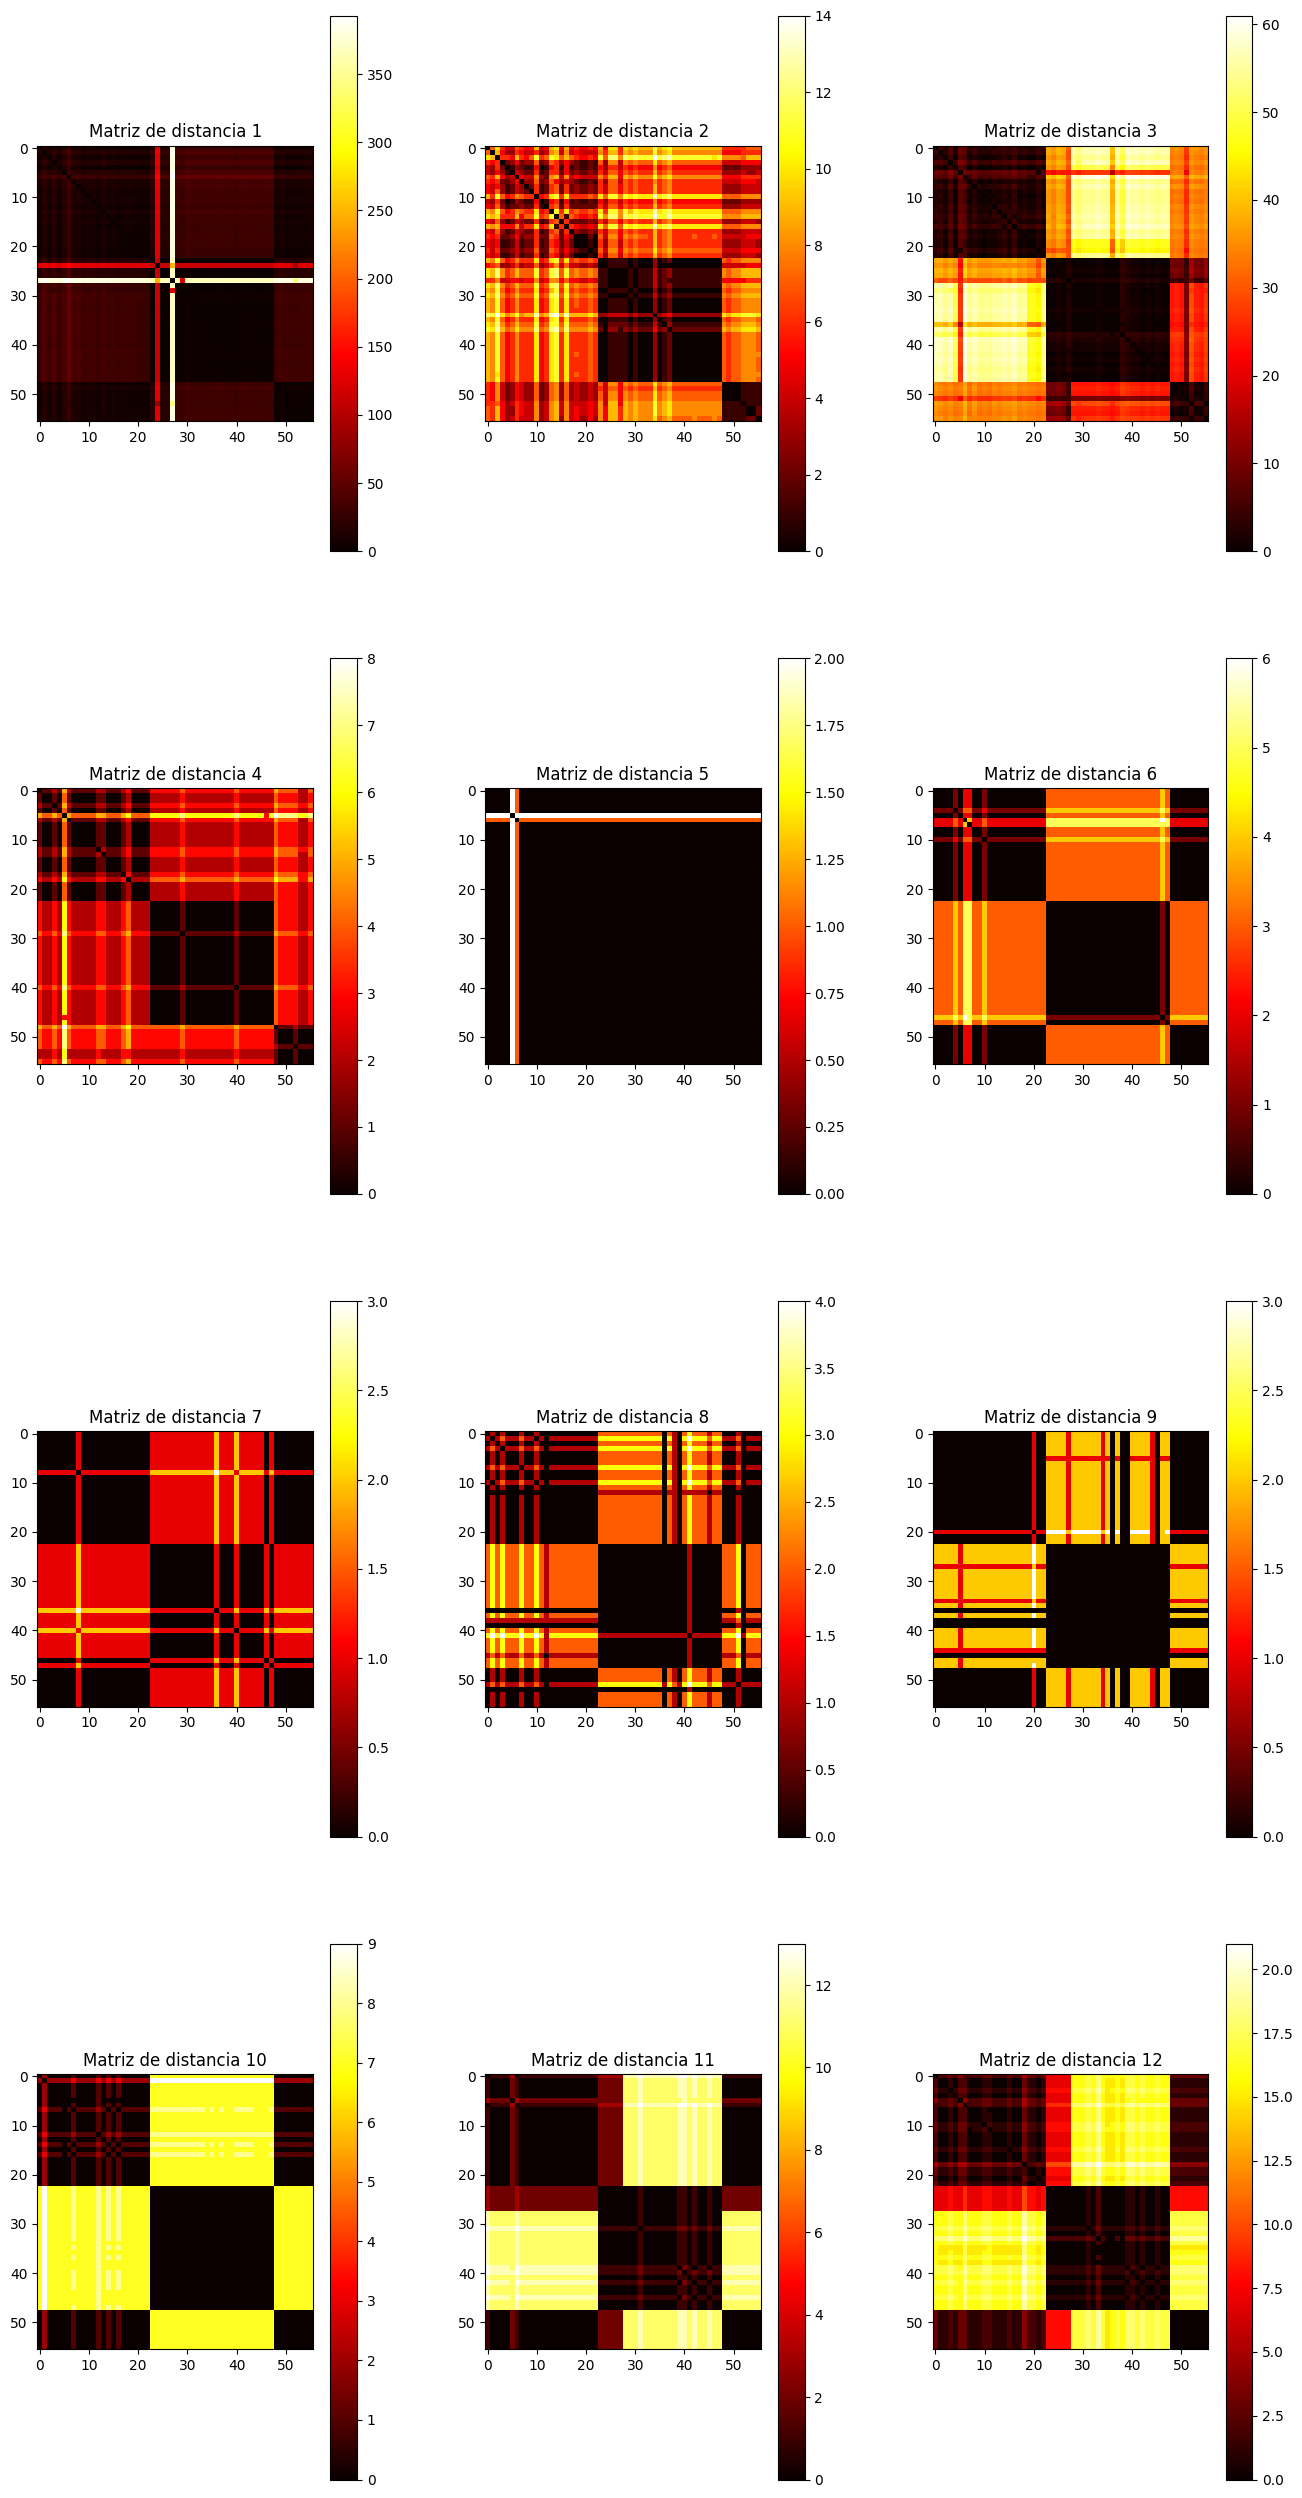

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Crea una figura con 3 filas y 4 columnas
fig,axs = plt.subplots(4, 3, figsize=(16, 32))

# Itera sobre cada matriz de distancia y subplot
for i, dist_matrix in enumerate(matriz_vector):
    row, col = i // 3, i % 3  # Calcula la fila y columna correspondientes
    
    # Grafica la matriz de distancia como una gráfica de calor
    im = axs[row, col].imshow(dist_matrix, cmap='hot')
    
    # Personaliza el subplot
    axs[row, col].set_title(f'Matriz de distancia {i+1}')
    
    # Agrega una barra de colores
    fig.colorbar(im, ax=axs[row, col])

# Ajusta el espaciado entre subplots
plt.subplots_adjust(wspace=.3, hspace=.2)

# Muestra la figura
plt.show()

In [18]:
import argparse
import numpy as np
import gudhi
import matplotlib.pyplot as plot

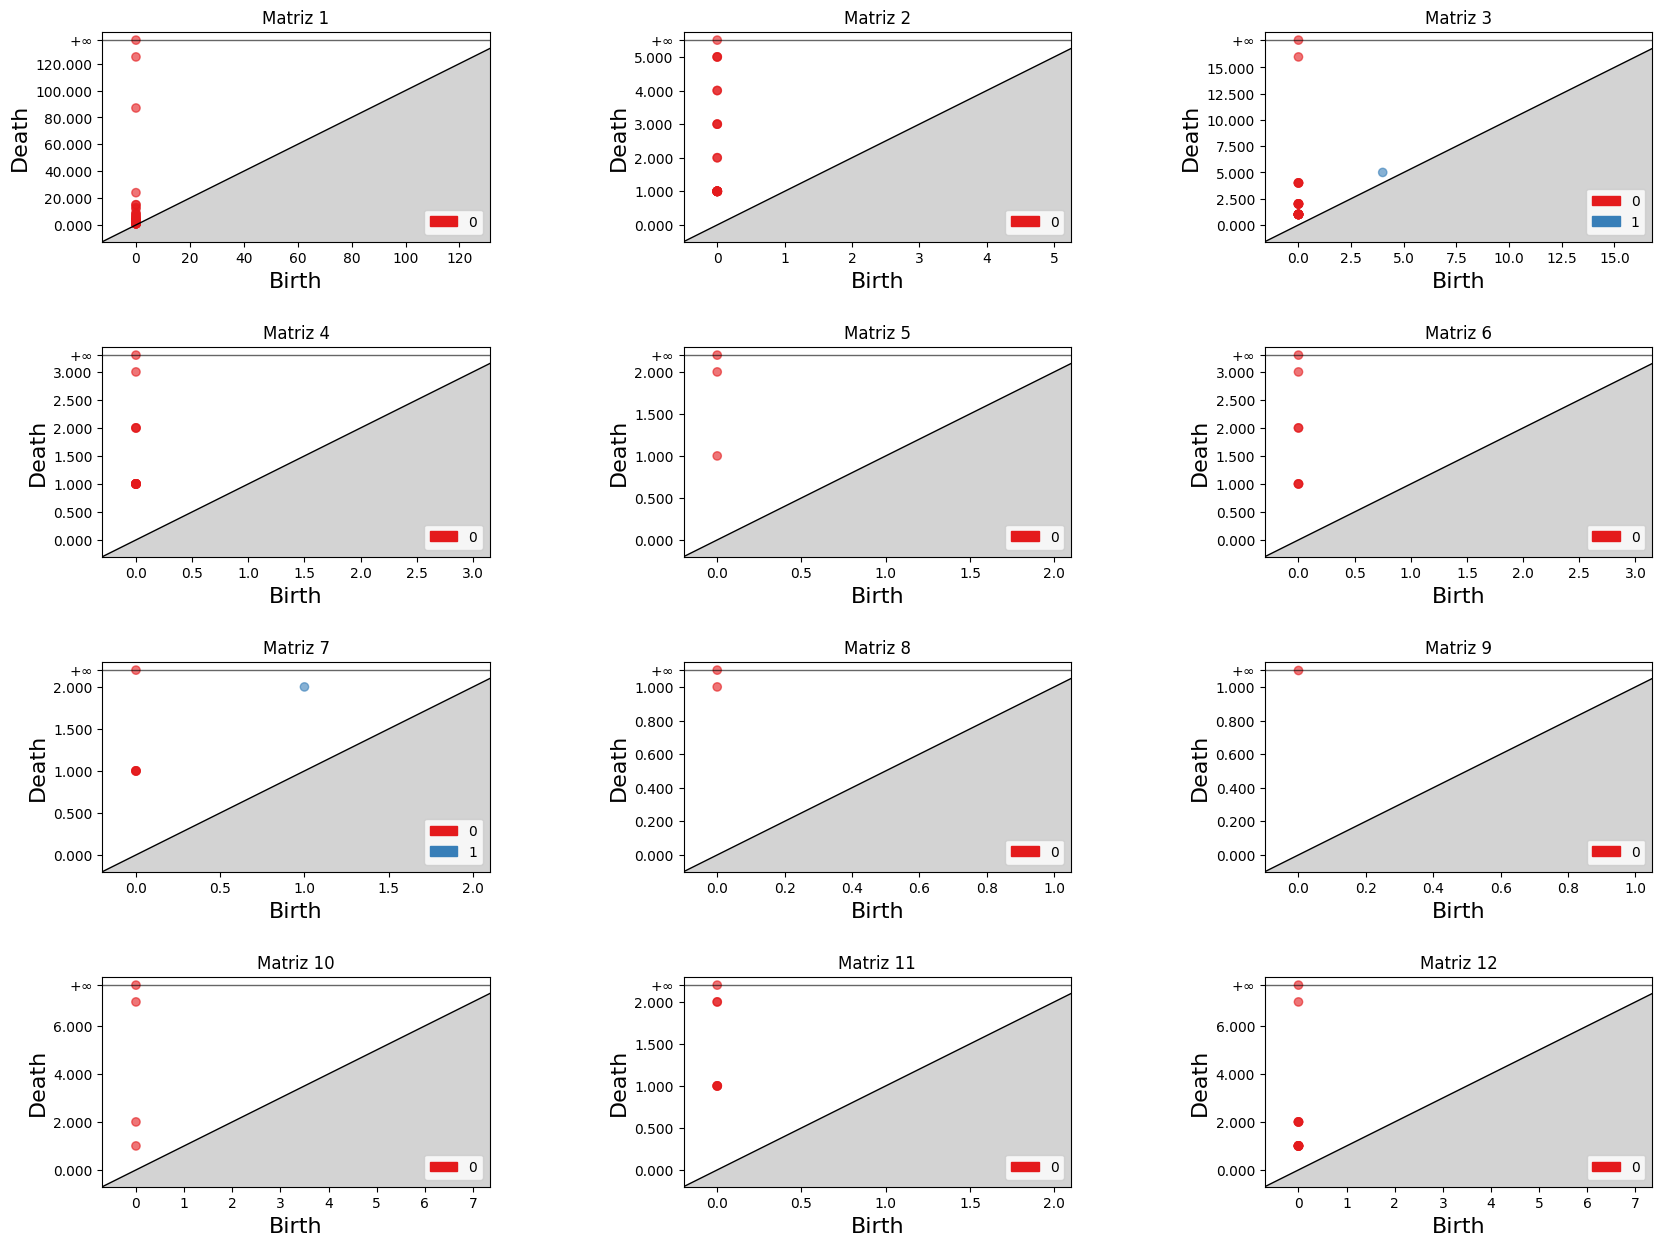

In [30]:
import matplotlib.pyplot as plt

# Crea una figura grande
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(20, 15))

# Itera sobre cada matriz y grafica su diagrama de persistencia en un subplot
for i, dist_matrix in enumerate(matriz_vector):
    row = i // 3  # Fila del subplot
    col = i % 3   # Columna del subplot
    ax = axs[row, col]  # Obtiene el subplot correspondiente
    
    # Crea un RipsComplex para la matriz actual
    max_edge_length = 360
    max_dimension = 3
    band = 0.0
    rips_complex = gudhi.RipsComplex(distance_matrix=dist_matrix, max_edge_length=max_edge_length)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=max_dimension)
    diag = simplex_tree.persistence()
    
    # Grafica el diagrama de persistencia en el subplot
    gudhi.plot_persistence_diagram(diag, axes=ax)
    ax.set_title(f'Matriz {i+1}')

# Ajusta el espaciado entre subplots
plt.subplots_adjust(hspace=0.5, wspace=0.5)

# Muestra la figura
plt.show()

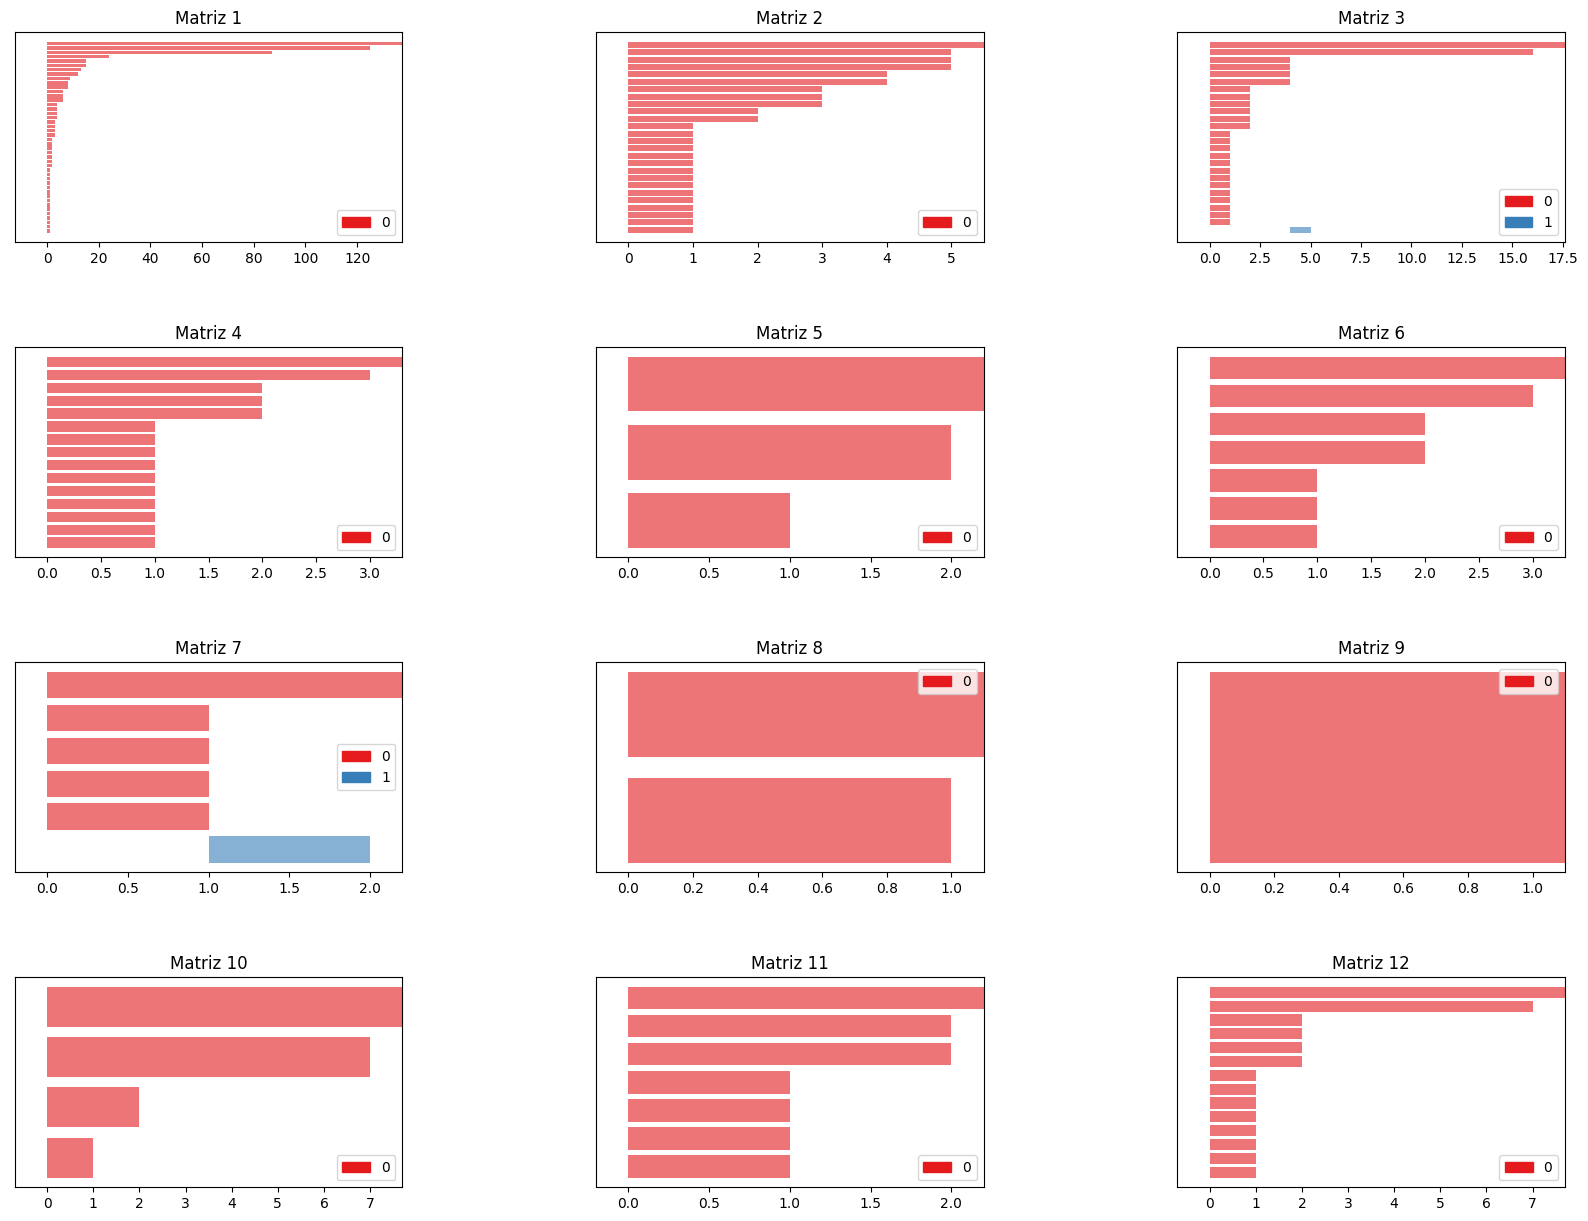

In [29]:
# Crea una figura grande
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(20, 15))

# Itera sobre cada matriz y grafica su diagrama de persistencia en un subplot
for i, dist_matrix in enumerate(matriz_vector):
    row = i // 3  # Fila del subplot
    col = i % 3   # Columna del subplot
    ax = axs[row, col]  # Obtiene el subplot correspondiente
    
    # Crea un RipsComplex para la matriz actual
    max_edge_length = 360
    max_dimension = 3
    band = 0.0
    rips_complex = gudhi.RipsComplex(distance_matrix=dist_matrix, max_edge_length=max_edge_length)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=max_dimension)
    diag = simplex_tree.persistence()
    
    # Grafica el diagrama de persistencia en el subplot
    gudhi.plot_persistence_barcode(diag, axes=ax)
    ax.set_title(f'Matriz {i+1}')

# Ajusta el espaciado entre subplots
plt.subplots_adjust(hspace=0.5, wspace=0.5)

# Muestra la figura
plt.show()